# Проект 7 - Возьмете бэтмобиль?

Целью проекта является предсказание цены автомобиля на основании имеющихся данных.
В качестве инструмента предполагается использовать методы традиционного машинного обучения а так же инструменты Deep learning: нейросети работающие с табличными данными, текстом и изображениями.

In [1]:
import numpy as np
import pandas as pd
import re
import os
import sys
import PIL
import cv2

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from category_encoders import TargetEncoder
from catboost import CatBoostRegressor

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
import albumentations

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Speedtriple\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Speedtriple\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Speedtriple\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Speedtriple\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# !pip3 install pandas-profiling==2.11
# !pip3 install category_encoders
# !pip3 install catboost
# !pip3 install --user tensorflow==2.3
# !pip install pymorphy2
# !pip3 install opencv-python
# !pip3 install --user albumentations

Подгрузим наши данные: тестовую и тренировочную выборки

In [3]:
DATA_DIR = 'C:/Users/Speedtriple/for anaconda/skillfactory_rds/module_9/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')

In [4]:
train.head()

bodyType     brand        color  \
0    седан       BMW       чёрный   
1    седан      AUDI  серебристый   
2    седан  MERCEDES       чёрный   
3    седан      AUDI        белый   
4  лифтбек      AUDI        белый   

                                         description engineDisplacement  \
0  Авто на бодром ходу.  Все работает отлично.  П...            3.0 LTR   
1  Продажа от собственника, второй владелец, ПТС ...            2.8 LTR   
2  Внимание! Только для клиентов AVILON Автомобил...            3.5 LTR   
3  В комплекте зимние колёса. 27.07.2020 Замена п...            2.0 LTR   
4  Отличный авто, 2011 года выпуска, кроме передн...            1.8 LTR   

  enginePower fuelType  mileage  modelDate model_info  ...      price  \
0     272 N12   бензин   245000       2007        5ER  ...   599000.0   
1     204 N12   бензин   183000       2011         A6  ...   850000.0   
2     306 N12   бензин   122733       2009   E_KLASSE  ...  1325000.0   
3     180 N12   бензин   151000       2011         A6  ...   815000.0   
4     160 N12   бензин   140000       2007         A5  ...   810000.0   

   productionDate     sell_id   vehicleConfiguration  vehicleTransmission  \
0            2007  1099980990    SEDAN AUTOMATIC 3.0       автоматическая   
1            2011  1095836906     SEDAN VARIATOR 2.8             вариатор   
2            2013  1100195530    SEDAN AUTOMATIC 3.5       автоматическая   
3            2011  1099880662     SEDAN VARIATOR 2.0             вариатор   
4            2011  1083244610  LIFTBACK VARIATOR 1.8             вариатор   

     Владельцы            Владение       ПТС    Привод   Руль  
0  3 или более                 NaN  Оригинал    полный  Левый  
1  2 владельца   8 лет и 6 месяцев  Оригинал  передний  Левый  
2  3 или более                 NaN  Оригинал    полный  Левый  
3  3 или более  4 года и 9 месяцев  Оригинал  передний  Левый  
4  3 или более  2 года и 9 месяцев  Оригинал  передний  Левый  

[5 rows x 22 columns]

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

Офрмим в виде функции нашу метрику как mean absolute percentage error (в sklearn есть такая метрика, но она работает только в версии 0.24, в гугл коллаб например она не запускается)

In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# Зафиксируем random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Наивная модель

Построим базовую модель на основе линейной регрессии для определения базового значения метрики.

In [8]:
X = train[['productionDate', 'mileage']]
y = train['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [9]:
naive_model = LinearRegression()

naive_model.fit(X_train, y_train)
y_pred = naive_model.predict(X_test)
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred)*100, '%')

MAPE: 68.3694800643878 %


Очень большое значение ошибки, но ниже этого ориентира падать точно нельзя.

## EDA

Проведем разведывательный анализ данных

In [10]:
# Размечаем трейн и тест
train['sample'] = 1
test['sample'] = 0
test['price'] = 0

# Объединяем датасеты
all_data = pd.concat([train, test], axis=0, ignore_index=bool)

In [11]:
all_data.tail()

bodyType brand       color  \
8348              седан   BMW  коричневый   
8349  внедорожник 5 дв.   BMW       синий   
8350  внедорожник 5 дв.  AUDI       белый   
8351              седан   BMW       белый   
8352              седан  AUDI      чёрный   

                                            description engineDisplacement  \
8348  Продаётся любимица семьи. Автомобилем неактивн...            2.0 LTR   
8349  В продаже автомобиль от компании АО ABTODOM, о...            3.0 LTR   
8350  Машина в идеальном техническом состоянии. Обсл...            1.4 LTR   
8351  Автомобиль приобретался новым у дилера Avilon ...            2.0 LTR   
8352  ID: 38887\nКомплектация-Comfort\nГод выпуска в...            2.0 LTR   

     enginePower fuelType  mileage  modelDate model_info  ... productionDate  \
8348     184 N12   бензин    76000       2011        3ER  ...           2012   
8349     218 N12   дизель   120381       2013         X5  ...           2017   
8350     150 N12   бензин    25790       2014         Q3  ...           2016   
8351     184 N12   бензин   104000       2009        5ER  ...           2013   
8352     225 N12   бензин   112434       2011         A4  ...           2014   

         sell_id           vehicleConfiguration  vehicleTransmission  \
8348  1099414488            SEDAN AUTOMATIC 2.0       автоматическая   
8349  1099277058  ALLROAD_5_DOORS AUTOMATIC 3.0       автоматическая   
8350  1098773964      ALLROAD_5_DOORS ROBOT 1.4     роботизированная   
8351  1098835932            SEDAN AUTOMATIC 2.0       автоматическая   
8352  1099834690                SEDAN ROBOT 2.0     роботизированная   

        Владельцы            Владение       ПТС    Привод   Руль sample  
8348  2 владельца               7 лет  Оригинал    задний  Левый      0  
8349   1 владелец                 NaN  Оригинал    полный  Левый      0  
8350  2 владельца   3 года и 3 месяца  Оригинал  передний  Левый      0  
8351   1 владелец  6 лет и 10 месяцев  Оригинал    задний  Левый      0  
8352  3 или более                 NaN  Дубликат    полный  Левый      0  

[5 rows x 23 columns]

In [12]:
# Воспользуемся профайлером
all_data_review = pandas_profiling.ProfileReport(all_data)

# Зафиксируем результат в ноутбуке
all_data_review.to_notebook_iframe()

# Сохраним отчет в виде html файла
all_data_review.to_file('all_data_review.html')

Summarize dataset:   0%|          | 0/36 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   object 
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  price                 8353 non-null   float64
 13  productionDate        8353 non-null   int64  
 14  sell_id               8353 non-null   int64  
 15  vehicleConfiguration 

Сделаем промжуточные выводы на основе отчета профайлера.
1. Датасет содержит 8353 примера и 23 признака
2. В колонках "Владение" и "Владельцы" есть пропуски, причем колонку "владение" вряд ли удасться заполнить, т.к. пропусков много
3. Колонка "name" дублирует данные в колонках "enginePower", "engineDisplacement", "Привод". Признак использовать не будем
4. Колонка "vehicleConfiguration" так же дублирует данные из других колонок. Признак использовать не будем.
5. Признак "sell_id" не несет никакой смысловой нагрузки))

Посмотрим на отдельные признаки более внимательно.

### bodyType

In [14]:
all_data['bodyType'].unique()

array(['седан', 'лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.',
       'минивэн', 'универсал 5 дв.', 'купе-хардтоп', 'купе', 'кабриолет',
       'родстер', 'хэтчбек 3 дв.', 'компактвэн', 'пикап двойная кабина',
       'внедорожник открытый', 'седан 2 дв.', 'внедорожник 3 дв.',
       'лимузин'], dtype=object)

In [15]:
all_data['bodyType'].value_counts()

седан                   3541
внедорожник 5 дв.       2896
купе                     543
хэтчбек 5 дв.            364
лифтбек                  299
универсал 5 дв.          196
минивэн                  178
купе-хардтоп             111
родстер                   88
хэтчбек 3 дв.             57
кабриолет                 54
компактвэн                 8
внедорожник 3 дв.          5
лимузин                    5
внедорожник открытый       4
пикап двойная кабина       3
седан 2 дв.                1
Name: bodyType, dtype: int64

### brand

In [16]:
all_data['brand'].unique()

array(['BMW', 'AUDI', 'MERCEDES'], dtype=object)

### color

In [17]:
all_data['color'].value_counts()

чёрный         3468
белый          1607
серый           925
синий           863
серебристый     420
коричневый      386
красный         266
голубой          91
зелёный          86
бежевый          85
фиолетовый       46
пурпурный        38
оранжевый        30
золотистый       24
жёлтый           17
розовый           1
Name: color, dtype: int64

### engineDisplacement

In [18]:
all_data['engineDisplacement'].value_counts()

2.0 LTR          2430
3.0 LTR          2349
1.8 LTR           411
1.6 LTR           410
4.4 LTR           329
5.5 LTR           268
3.5 LTR           250
2.5 LTR           248
2.1 LTR           221
4.0 LTR           153
4.7 LTR           137
2.8 LTR           106
1.4 LTR           106
4.2 LTR           103
5.0 LTR            74
1.5 LTR            73
3.2 LTR            60
2.2 LTR            58
4.8 LTR            57
2.9 LTR            50
3.1 LTR            44
2.4 LTR            44
6.2 LTR            40
6.0 LTR            37
5.4 LTR            33
1.2 LTR            33
1.3 LTR            32
2.7 LTR            24
4.1 LTR            23
3.6 LTR            23
1.7 LTR            15
2.3 LTR            14
3.7 LTR            14
5.2 LTR            13
5.9 LTR            11
2.6 LTR             9
0.7 LTR             6
undefined LTR       6
6.6 LTR             5
4.6 LTR             5
1.9 LTR             5
5.8 LTR             5
4.3 LTR             4
3.4 LTR             4
5.6 LTR             3
3.8 LTR   

Хотелось бы перевести этот признак в числовой, но мешает значение "undefined LTR". Посмотрим на строки с этим значением.

In [19]:
all_data[all_data['engineDisplacement'].str.match('undefined LTR')]

bodyType brand        color  \
2296  хэтчбек 5 дв.   BMW       чёрный   
3725  хэтчбек 5 дв.   BMW       чёрный   
3726  хэтчбек 5 дв.   BMW      голубой   
5862  хэтчбек 5 дв.   BMW        белый   
6283  хэтчбек 5 дв.   BMW       чёрный   
7687  хэтчбек 5 дв.   BMW  серебристый   

                                            description engineDisplacement  \
2296  Автомобиль в наличии Москве , с ПТС , производ...      undefined LTR   
3725  BMW i3 Электромобиль с бензиновым генератором,...      undefined LTR   
3726  Прибыло из Америки в августе 20 года. Полная и...      undefined LTR   
5862  В наличии! Автомобиль куплен в США! Комплектац...      undefined LTR   
6283  Авто в идеальном состоянии\nЕсть REX (range ex...      undefined LTR   
7687                                                  .      undefined LTR   

     enginePower fuelType  mileage  modelDate model_info  ... productionDate  \
2296     184 N12  электро     9000       2017         I3  ...           2019   
3725     170 N12  электро    39500       2017         I3  ...           2017   
3726     170 N12  электро    28800       2017         I3  ...           2017   
5862     170 N12  электро    35810       2013         I3  ...           2016   
6283     170 N12  электро    60000       2013         I3  ...           2015   
7687     170 N12  электро    89942       2013         I3  ...           2014   

         sell_id         vehicleConfiguration  vehicleTransmission  \
2296  1100083262  HATCHBACK_5_DOORS AUTOMATIC       автоматическая   
3725  1098041130  HATCHBACK_5_DOORS AUTOMATIC       автоматическая   
3726  1100097316  HATCHBACK_5_DOORS AUTOMATIC       автоматическая   
5862  1100153696  HATCHBACK_5_DOORS AUTOMATIC       автоматическая   
6283  1097395090  HATCHBACK_5_DOORS AUTOMATIC       автоматическая   
7687  1100166318  HATCHBACK_5_DOORS AUTOMATIC       автоматическая   

       Владельцы             Владение       ПТС  Привод   Руль sample  
2296  1 владелец                  NaN  Оригинал  задний  Левый      1  
3725  1 владелец  2 года и 11 месяцев  Оригинал  задний  Левый      1  
3726  1 владелец                  NaN  Оригинал  задний  Левый      1  
5862  1 владелец                  NaN  Оригинал  задний  Левый      1  
6283  1 владелец                  NaN  Оригинал  задний  Левый      1  
7687  1 владелец                  NaN  Оригинал  задний  Левый      0  

[6 rows x 23 columns]

Все представленные авто - электромобили, заполнять значения объема нулем пожалуй не корректно, оставим данный признак категориальным

### engine power

In [20]:
# Приведем мощность к числовому формату
all_data['enginePower'] = all_data['enginePower'].apply(lambda x: int(x[:-4]))
print(all_data['enginePower'])

0       272
1       204
2       306
3       180
4       160
       ... 
8348    184
8349    218
8350    150
8351    184
8352    225
Name: enginePower, Length: 8353, dtype: int64


### Владельцы

В колонке "Владельцы" присутствует один пропуск. Посмотрим чем мы можем его заполнить

In [21]:
all_data['Владельцы'].unique()

array(['3 или более', '2\xa0владельца', '1\xa0владелец', nan],
      dtype=object)

In [22]:
nan_string = all_data[(all_data['Владельцы']!= '1\xa0владелец') & 
             (all_data['Владельцы']!= '2\xa0владельца') & 
             (all_data['Владельцы']!= '3 или более')]
nan_string

bodyType brand   color  \
4994    седан  AUDI  чёрный   

                                            description engineDisplacement  \
4994  машина в идеале! вложено примерно 400тыс.руб \...            4.2 LTR   

      enginePower fuelType  mileage  modelDate model_info  ... productionDate  \
4994          360   бензин   160000       1999         S8  ...           2001   

         sell_id  vehicleConfiguration  vehicleTransmission  Владельцы  \
4994  1019330519   SEDAN AUTOMATIC 4.2       автоматическая        NaN   

                Владение       ПТС  Привод   Руль sample  
4994  10 лет и 7 месяцев  Оригинал  полный  Левый      1  

[1 rows x 23 columns]

In [23]:
all_data.loc[4994]['description']

'машина в идеале! вложено примерно 400тыс.руб \r\n замена ГРМ, всех расходников,\r\n двигатель контрактный с пробегом в 120,000км.\r\n рулевая рейка новая (не ремонтная а НОВАЯ!)\r\n новый кардан. \r\n новые гидро натяжители цепей 40тыс.руб. \r\n новый бензонасос, \r\n новая подвеска "бильштайн" \r\n и т.д. \r\n комплектация максимальная- черное дерево! штатный (снимаемый) фаркоп, предпусковой подогреватель WEBASTO, кованные диски (германия) R-20, телефон.\r\nНА ВТОРОМ ФОТО СТАРЫЙ РУЛЬ! СЕЙЧАС НОВЫЙ С ДЕРЕВОМ КАК НА ПОСЛЕДНИХ ФОТО... (старый отдам в довесок)\r\nнедавно сделана полная разводка глушителей, с установкой новых банок на обе трубы (на фото можно разглядеть снизу) банки от ренж ровер спорт, звук КЛАСС!!!\r\n много писать, звоните...\r\nфото 100% мои!\r\nвозможен обмен на битый или горевший  микроавтобус (фольксваген Т-5) мультиван свежих годов.\r\nСАЛОНЫ И ПРОЧИЕ "ПОМОЩНИКИ" ИДИТЕ ЛЕСОМ!!!!!!!!!\r\nфото 100% мои!\r\nпродажа НЕ срочная!!! с большим торгом не звонить.'

Машина 2001 года выпуска, последний хозяин владеет ей около 10 лет, т.е хозяев как минимум два и вряд ли первые 9 лет машина была в одних руках, тот кто новыми такие дорогие тачки берет долго их у себя не держит. Напишу "3 и более"

In [24]:
all_data['Владельцы'].fillna('3 или более', inplace=True)

In [25]:
# Количество владельцев переведем в числовой формат
all_data['Владельцы'] = all_data['Владельцы'].apply(lambda x: int(x[0]))
print(all_data['Владельцы'])

0       3
1       2
2       3
3       3
4       3
       ..
8348    2
8349    1
8350    2
8351    1
8352    3
Name: Владельцы, Length: 8353, dtype: int64


### fuel type

In [26]:
all_data['fuelType']

0       бензин
1       бензин
2       бензин
3       бензин
4       бензин
         ...  
8348    бензин
8349    дизель
8350    бензин
8351    бензин
8352    бензин
Name: fuelType, Length: 8353, dtype: object

### mileage

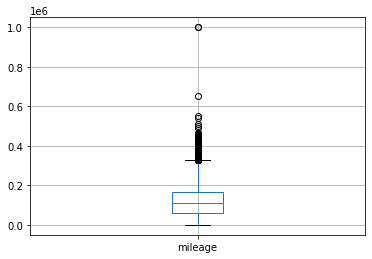

In [27]:
all_data['mileage'].plot(kind = 'box', grid = True)

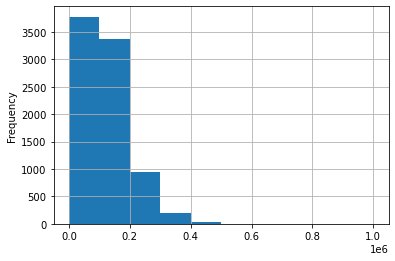

In [28]:
#all_data['mileage'] = np.log(all_data['mileage'])
all_data['mileage'].plot(kind = 'hist', grid = True)

### modelDate

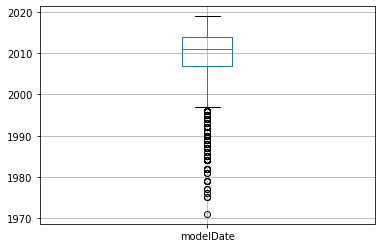

In [29]:
all_data['modelDate'].plot(kind='box', grid=True)

### number of doors

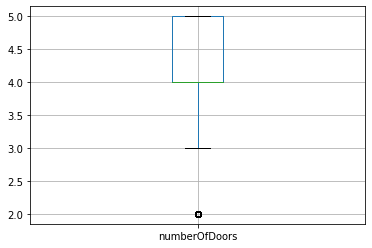

In [30]:
all_data['numberOfDoors'].plot(kind='box', grid=True)

### productionDate

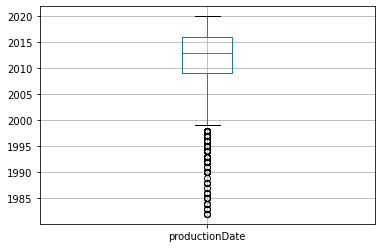

In [31]:
all_data['productionDate'].plot(kind='box', grid=True)

Как видим в числовых данных много выбросов. Слишком много чтоб их удалять. Учтем этот факт в дальнейшем при стандартизации

In [32]:
all_data.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'price', 'productionDate', 'sell_id',
       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение',
       'ПТС', 'Привод', 'Руль', 'sample'],
      dtype='object')

Отметим переменные в колонках которые будем использовать для машинного обучения как категориальные, числовые и бинарные.

In [33]:
num_col = ['enginePower', 'Владельцы', 'mileage', 'modelDate', 'productionDate', 'numberOfDoors'] # Числовые переменные
cat_col = ['bodyType', 'brand', 'color','engineDisplacement',
           'fuelType',  'model_info', 'vehicleTransmission', 'Привод'] # Категориальные переменные
bin_col = ['ПТС', 'Руль'] # Бинарные переменные

In [34]:
# Обработаем категориальные данные One hot encoder-ом
one_hot_enc = OneHotEncoder(sparse = False)
one_hot_enc.fit(all_data[cat_col].values)

# Поскольку у числовых данных много выбросов выберем для стандартизации Robust scaler
rb_scaler = RobustScaler()
rb_scaler.fit(all_data[num_col].values)

# Бинарные переменные закодируем label encoder-ом
label_encoder = LabelEncoder()

for column in bin_col:
    all_data[column] = label_encoder.fit_transform(all_data[column])

Поделим наши преобразованные данные снова на трейн и тест

In [35]:
data_train = all_data.query('sample == 1').drop(['sample'], axis=1)
data_test = all_data.query('sample == 0').drop(['sample'], axis=1)

In [36]:
data_train.head()

bodyType     brand        color  \
0    седан       BMW       чёрный   
1    седан      AUDI  серебристый   
2    седан  MERCEDES       чёрный   
3    седан      AUDI        белый   
4  лифтбек      AUDI        белый   

                                         description engineDisplacement  \
0  Авто на бодром ходу.  Все работает отлично.  П...            3.0 LTR   
1  Продажа от собственника, второй владелец, ПТС ...            2.8 LTR   
2  Внимание! Только для клиентов AVILON Автомобил...            3.5 LTR   
3  В комплекте зимние колёса. 27.07.2020 Замена п...            2.0 LTR   
4  Отличный авто, 2011 года выпуска, кроме передн...            1.8 LTR   

   enginePower fuelType  mileage  modelDate model_info  ...      price  \
0          272   бензин   245000       2007        5ER  ...   599000.0   
1          204   бензин   183000       2011         A6  ...   850000.0   
2          306   бензин   122733       2009   E_KLASSE  ...  1325000.0   
3          180   бензин   151000       2011         A6  ...   815000.0   
4          160   бензин   140000       2007         A5  ...   810000.0   

   productionDate     sell_id   vehicleConfiguration  vehicleTransmission  \
0            2007  1099980990    SEDAN AUTOMATIC 3.0       автоматическая   
1            2011  1095836906     SEDAN VARIATOR 2.8             вариатор   
2            2013  1100195530    SEDAN AUTOMATIC 3.5       автоматическая   
3            2011  1099880662     SEDAN VARIATOR 2.0             вариатор   
4            2011  1083244610  LIFTBACK VARIATOR 1.8             вариатор   

  Владельцы            Владение  ПТС    Привод  Руль  
0         3                 NaN    1    полный     0  
1         2   8 лет и 6 месяцев    1  передний     0  
2         3                 NaN    1    полный     0  
3         3  4 года и 9 месяцев    1  передний     0  
4         3  2 года и 9 месяцев    1  передний     0  

[5 rows x 22 columns]

При помощи инструмента f_classif оценим значимость числовых признаков

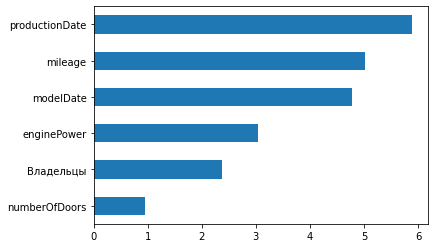

In [37]:
# - визуализация важности числовых признаков 
imp_num = pd.Series(f_classif(data_train[num_col], data_train['price'])[0], index = num_col)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Как и ожидалось самые знаимые признаки дата производства и пробег

Теперь оценим значимость категориальных и бинарных признаков при помощи mutual_f_classif

In [38]:
# Сделаем копию трейнового датасета
data_for_grade = data_train.copy()

# для простоты закодируем категориалные признаки label encoder-ом
for column in cat_col:
    data_for_grade[column] = label_encoder.fit_transform(data_for_grade[column])

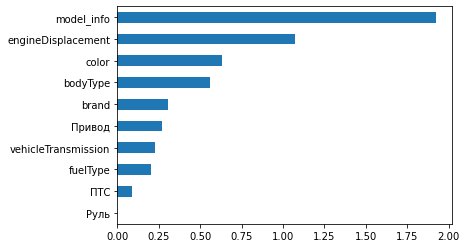

In [39]:
# - визуализация важности бинарных и категориальных признаков
imp_cat = pd.Series(mutual_info_classif(data_for_grade[bin_col + cat_col], data_for_grade['price'],
                                     discrete_features =True), index = bin_col + cat_col)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Самый важный признак - название модели, самый незначительный расположение руля ("праворуких" немцев мало, что не удивительно и  2 наблюдения с правым рулем погоды не делают, хотя на деле расположение руля оказывает большое влияние на цену). Для анализа оставим все признаки.

## CatBoost

Построим модель предсказания цены на основе алгоритма CatBoost

In [40]:
# Сформируем массив нулей и единиц взамен категориальных признаков
X_cat = one_hot_enc.transform(data_train[cat_col].values)

# Стандартизируем числовые признаки
X_num = rb_scaler.transform(data_train[num_col].values)

# Объединяем нужные нам признаки в один массив
X = np.hstack([X_num, data_train[bin_col].values, X_cat])

# Обозначачем таргет
y = data_train['price'].values

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Поскольку распределение таргета не нормально воспользуемся его логарифмированием и напишем модель.

In [42]:
kitty = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
kitty.fit(X_train, np.log(y_train+1),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test+1)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

test_predict_catboost = np.exp(kitty.predict(X_test))-1
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, test_predict_catboost)*100,'%')

MAPE: 11.360374596480941 %


Хорошая метрика. По сравнению с наивной моделью просто превосходная!

In [43]:
# Обработаем признаки для тестовой выборки
X_cat = one_hot_enc.transform(data_test[cat_col].values)
X_num = rb_scaler.transform(data_test[num_col].values)
X_sub = np.hstack([X_num, data_test[bin_col].values, X_cat])

In [44]:
# Предсказываем цены в тестовой выборке
predict_submission_cat = np.exp(kitty.predict(X_sub))-1

In [45]:
sample_submission = test[['sell_id']]

sample_submission['price'] = predict_submission_cat
#sample_submission.to_csv('submission_prediction_catboost.csv', index=False)
sample_submission.head()

<ipython-input-45-b26261231836>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_submission['price'] = predict_submission_cat


sell_id         price
0  1099427284  8.112341e+05
1  1096405886  2.668968e+06
2  1100195294  6.378996e+05
3  1099827282  4.804512e+05
4  1100076198  2.710072e+06

На кагле результат метрики равен 12.118%

## Простая нейронка

Создадим трехслойную нейронную сеть обучающуюся на табличных данных

In [46]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [47]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [48]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [49]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

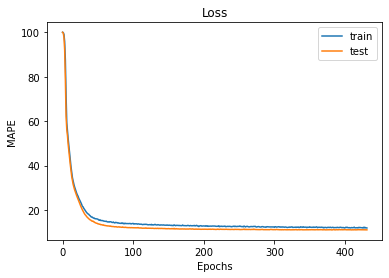

In [50]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend(loc = 1)
plt.show();

In [51]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.10%


По сравнению с cat boost метрика улучшилась

In [52]:
predict_submission_mlp = model.predict(X_sub)

In [53]:
#sample_submission = test[['sell_id']]

#sample_submission['price'] = predict_submission
#sample_submission.to_csv('submission_prediction_mlp.csv', index=False)
#sample_submission.head()

На kaggle результат метрики 11.222%. Есть улучшение!

## Multi-Input сеть: табличные данные + текст

Создадим сеть обрабатывающую как табличные данные так и текст из колонки "description"

In [54]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

Разбиваем данные на тренировочные (X_train), валидационные (X_test) и тестовые (X_sub)

In [55]:
text_train = all_data.description.iloc[(pd.DataFrame(X_train)).index]
text_test = all_data.description.iloc[(pd.DataFrame(X_test)).index]
text_sub = all_data.description.iloc[(pd.DataFrame(X_sub)).index]

In [56]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words("russian"))

Пишем функцию исключающую из описания цифры, знаки препинания, стоп-слова, а так же переводящую слова в именительный падеж.

In [57]:
from tqdm import tqdm
import pymorphy2

def preprocces(X):
    X_proccess = []
    morph = pymorphy2.MorphAnalyzer()

    for x in tqdm(X):
        x = re.sub('[0-9]', '', x)
        x = x.lower()
        x = nltk.word_tokenize(x)
        x = [word for word in x if word.isalnum()]
        x = [morph.parse(w)[0].normal_form for w in x]
        x = [word for word in x if not word in stop_words]
        X_proccess.append(' '.join(x))
    return X_proccess

Обрабатываем наши корпуса текстов

In [58]:
X_train_proc = preprocces(text_train)
X_test_proc = preprocces(text_test)
X_sub_proc = preprocces(text_sub)

100%|██████████████████████████████████████████████████████████████████████████████| 1671/1671 [00:35<00:00, 46.58it/s]


Сравним текст до обработки и после обработки

In [59]:
print(text_train[1])

Продажа от собственника, второй владелец, ПТС оригинал.
Отличное состояние, вложений не требует.
Комплект новой зимней резины Nokian.
По кузову мелкие притертости. В базе бьется как 2 ДТП, т.к. все зарегистрировано в ГИБДД.
Обслуживание только у официального дилера, сервисная книжка в наличии. Пройдено ТО.
Все ключи.
Эксплуатация с 2012 года.
Хорошая комплектация + дополнительное оборудование.
Продажа через ГИБДД.


In [60]:
print(X_train_proc[1])

продажа собственник второй владелец птс оригинал отличный состояние вложение требовать комплект новый зимний резина nokian кузов мелкий притертость база биться дтп всё зарегистрировать гибдд обслуживание официальный дилер сервисный книжка наличие пройти всё ключ эксплуатация год хороший комплектация дополнительный оборудование продажа гибдд


Отлично, обработка прошла успешно!

Теперь посчитаем сколько слов в нашем словаре, чтобы передать этот параметр в слой Embedding nlp-нейросети

In [61]:
glossary = []
for sentence in X_train_proc, X_test_proc, X_sub_proc:
    for word in sentence:
        if word not in glossary:
            glossary.append(word)
        else:
            continue
print(len(glossary))            

4813


In [62]:
tokenize = Tokenizer(num_words=MAX_WORDS)

Проводим векторизацию текста

In [63]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(X_train_proc), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(X_test_proc), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(X_sub_proc), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5345, 256) (1337, 256) (1671, 256)
Wall time: 566 ms


In [64]:
# Часть сети обрабатывающей текст
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(glossary)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

In [65]:
# Часть сети обрабатывющей табличные данные
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [66]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [67]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [68]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [228]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
11/11 [==============================] - 61s 6s/step - loss: 99.9948 - MAPE: 99.9948 - val_loss: 99.9440 - val_MAPE: 99.9440
Epoch 2/500
11/11 [==============================] - 63s 6s/step - loss: 99.3861 - MAPE: 99.3861 - val_loss: 97.2318 - val_MAPE: 97.2318
Epoch 3/500
11/11 [==============================] - 65s 6s/step - loss: 90.1724 - MAPE: 90.1724 - val_loss: 71.7869 - val_MAPE: 71.7869
Epoch 4/500
11/11 [==============================] - 68s 6s/step - loss: 61.5913 - MAPE: 61.5913 - val_loss: 60.6322 - val_MAPE: 60.6322
Epoch 5/500
11/11 [==============================] - 81s 7s/step - loss: 54.3484 - MAPE: 54.3484 - val_loss: 49.0956 - val_MAPE: 49.0956
Epoch 6/500
11/11 [==============================] - 88s 8s/step - loss: 46.2826 - MAPE: 46.2826 - val_loss: 42.1746 - val_MAPE: 42.1746
Epoch 7/500
11/11 [==============================] - 95s 9s/step - loss: 39.5624 - MAPE: 39.5624 - val_loss: 36.0992 - val_MAPE: 36.0992
Epoch 8/500
11/11 [======================

Epoch 60/500
11/11 [==============================] - 108s 10s/step - loss: 12.2688 - MAPE: 12.2688 - val_loss: 11.4849 - val_MAPE: 11.4849
Epoch 61/500
11/11 [==============================] - 107s 10s/step - loss: 12.2559 - MAPE: 12.2559 - val_loss: 11.5289 - val_MAPE: 11.5289
Epoch 62/500
11/11 [==============================] - 108s 10s/step - loss: 12.1241 - MAPE: 12.1241 - val_loss: 11.5143 - val_MAPE: 11.5143
Epoch 63/500
11/11 [==============================] - 107s 10s/step - loss: 12.1438 - MAPE: 12.1438 - val_loss: 11.4148 - val_MAPE: 11.4148
Epoch 64/500
11/11 [==============================] - 106s 10s/step - loss: 12.3567 - MAPE: 12.3567 - val_loss: 11.4376 - val_MAPE: 11.4376
Epoch 65/500
11/11 [==============================] - 110s 10s/step - loss: 12.2031 - MAPE: 12.2031 - val_loss: 11.3690 - val_MAPE: 11.3690
Epoch 66/500
11/11 [==============================] - 107s 10s/step - loss: 12.2381 - MAPE: 12.2381 - val_loss: 11.4762 - val_MAPE: 11.4762
Epoch 67/500
11/11 [

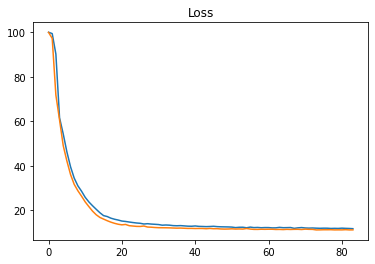

In [229]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

Оси и кривые аналогичны предыдущему графику (чтобы сделать так же здесь мне надо перезапускать обучение, а это часы, посему, извините, будет так)

In [231]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, test_predict_nn2)*100,'%')

MAPE: 11.213291227307378 %


Улучшения метрики нет. Работа с текстом не помогла.

In [233]:
predict_submission = model.predict([text_sub_sequences, X_sub])

In [234]:
sample_submission = test[['sell_id']]

sample_submission['price'] = predict_submission
sample_submission.to_csv('submission_prediction_mlp_nlp.csv', index=False)
sample_submission.head()

<ipython-input-234-1dd132321813>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_submission['price'] = predict_submission


sell_id         price
0  1099427284  5.214327e+05
1  1096405886  2.555176e+06
2  1100195294  6.283162e+05
3  1099827282  4.895919e+05
4  1100076198  2.891299e+06

На kaggle результат метрики 11.546%. Улучшения нет.

## Multi-Input сеть: табличные данные + текст + изображения

Добавим в нашу мульти-инпут сеть часть обрабатывющую картинки. Хоть часть обрабатывающаая текст и была бесполезна в нашем случае, оставим ее в учебных целях.

Свяжем имеющийся в задании набор фотографий с со значениями признака "sell_id"

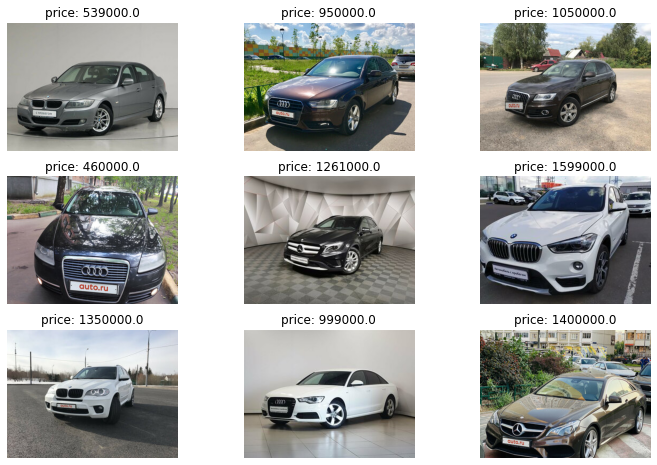

In [87]:
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Подгрузим эти картинки в память и создадим матрицу:

In [88]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(all_data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array((pd.DataFrame(X_train)).index)
images_test = get_image_array((pd.DataFrame(X_test)).index)
images_sub = get_image_array((pd.DataFrame(X_sub)).index)

images shape (5345, 240, 320, 3) dtype uint8
images shape (1337, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


Поскольку наш датасет не большой воспользуемся библиотекой albumentations для генерации новых вариантов картинок (аугментация)

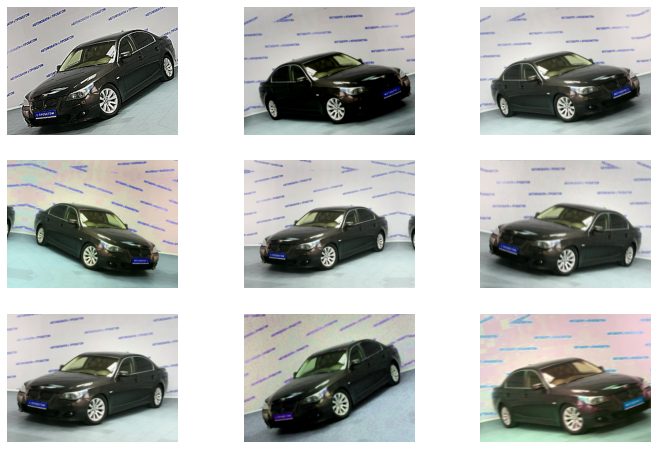

In [89]:
from albumentations import (
    HorizontalFlip, Perspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    GaussNoise, MotionBlur, MedianBlur, PiecewiseAffine,
    Sharpen, Emboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

augmentation = Compose([
    HorizontalFlip(),
    GaussNoise(p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    
    OneOf([
        CLAHE(clip_limit=2),
        Sharpen(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[15])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

Создадим функцию для аугментации.

In [90]:
def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
        augment_dict = augmentation(image = images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

Во избежании переполнения памяти во время обучения нейросети возпользуемся итератором tf. Напишем функции где задействуем этот итератор

In [91]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, X_train_proc, y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, X_test_proc, y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, X_sub_proc, y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

Дальше (да и выше тоже) какая-то магия. Спасибо skillfactory за наше счастливое детство.

In [92]:
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', 
                                                                       include_top = False, 
                                                                       input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [93]:
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [94]:
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(glossary)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [95]:
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)

In [96]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [97]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit(train_dataset.batch(30),
                    epochs=120, 
                    validation_data=test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/120
141/179 [======================>.......] - ETA: 6:41 - loss: 58.5968 - MAPE: 58.5968

На локальной машине посчитать такую сеть мне не удалось. Результат работы кода можно увидеть здесь: https://colab.research.google.com/drive/1puMfhbmddAXfCc1GlxFZgtnOp7EmnjVp#scrollTo=NN-fSN_DIIpO&line=1&uniqifier=1

Метрика MAPE на валидационной выборке равна 11.2%. Улучшения нет

На kaggle результат метрики 11.508%. Улучшения нет.

## Blend my brain with digits

Воспользуемся таким трюком как blending, т.е. усредним результаты работы сетей Deep Learning и Machine Learning. 

Приведу пример самого успешного блендинга в моем проекте: катбуст + простая нейронная сеть

In [64]:
blend_predict = (test_predict_catboost + test_predict_nn1[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.73%


На валидационных предсказаниях результат лучше!

In [69]:
blend_predict_sub = (predict_submission_cat + predict_submission_mlp[:,0]) / 2

In [70]:
sample_submission = test[['sell_id']]

sample_submission['price'] = blend_predict_sub
# sample_submission.to_csv('submission_prediction_blend_cat_mlp.csv', index=False)
sample_submission.head()

<ipython-input-70-043e226f47ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_submission['price'] = blend_predict_sub


sell_id         price
0  1099427284  7.076222e+05
1  1096405886  2.575262e+06
2  1100195294  6.392341e+05
3  1099827282  4.777600e+05
4  1100076198  2.759952e+06

На kaggle результат метрики 11.1509%. Есть улучшение! Со всеми результатами предсказаний можно ознакомиться здесь: https://www.kaggle.com/c/sf-dst-car-price-prediction-part2/submissions Ник на кагл: Nikolay Lukichev

## Проброс признака

В основе метода лежит идея о том что на вход мульт-инпут нейросети можно подавать отдельные признаки сильно влияющие на таргет. Здесь в юпитере код у меня не заработал, но в гугл коллабе я поигрался с соединением простой нейронки с такими признаками как "productiondate" и "mileage", улучшения результата не было. Ниже приведу код который показал лучший для этого метода результат на валидационной выборке в коллабе. Предсказание для кагла делать не стал, потому как метрика на валидационной выборке получалась около 12%.

In [98]:
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(all_data.productionDate.unique().tolist())+1, 20)(productiondate)

In [99]:
combinedInput = L.concatenate([model_mlp.output, L.Flatten()(emb_productiondate),])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [100]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [101]:
history = model.fit([X_train, (all_data.productionDate.iloc[(pd.DataFrame(X_train)).index]).values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test,  (all_data.productionDate.iloc[(pd.DataFrame(X_test)).index]).values], y_test),
                    callbacks=callbacks_list)

Epoch 1/500


InvalidArgumentError:  indices[0,0] = 2010 is not in [0, 40)
	 [[node functional_11/embedding_6/embedding_lookup (defined at <ipython-input-101-53f6e2314428>:1) ]] [Op:__inference_train_function_36831]

Errors may have originated from an input operation.
Input Source operations connected to node functional_11/embedding_6/embedding_lookup:
 functional_11/embedding_6/embedding_lookup/36528 (defined at C:\Users\Speedtriple\anaconda3\lib\contextlib.py:113)

Function call stack:
train_function


In [102]:
test_predict_nn4 = model.predict([X_test, (all_data.productionDate.iloc[(pd.DataFrame(X_test)).index]).values])
print(f"TEST mape: {(mape(y_test, test_predict_nn4[:,0]))*100:0.2f}%")

InvalidArgumentError:  indices[0,0] = 2007 is not in [0, 40)
	 [[node functional_11/embedding_6/embedding_lookup (defined at <ipython-input-102-c0ff8a8152cc>:1) ]] [Op:__inference_predict_function_36944]

Errors may have originated from an input operation.
Input Source operations connected to node functional_11/embedding_6/embedding_lookup:
 functional_11/embedding_6/embedding_lookup/36911 (defined at C:\Users\Speedtriple\anaconda3\lib\contextlib.py:113)

Function call stack:
predict_function


## Результаты и выводы

При выполнении проекта были пройдены следующие этапы:
1. Построена базовая (наивная) модель, установлено опорное значение метрики MAPE;
2. Проведен разведывательный анализ данных: заполнены пропуски, исключены неважные, дублирующие признаки, проведено кодирование категориальных и стандартизация числовых признаков;
3. Построена модель машинного обучения по алгоритму CatBoost, проведено сравнение метрики с результатом наивной модели, зафиксировано улучшение;
4. Построена модель на основе трехслойной нейросети, зафиксировано улучшение метрики по сравнению с результатом CatBoost;
5. Выполнена обработка признака description, построена multi input сеть принимающая на вход вывод с как обычной нейросети так и с сети обрабатывающей текстовые данные. Улучшения метрики по сравнению с простой нейросетью не зафиксировано;
5. Посредством связи фото автомобилей с признаком sell_id в датасет добавлены картинки, произведена аугментация картинок, построена multi input сеть принимающая на вход выводы сетей обрабатывающих картинки, текст и табличные данные. Улучшения метрики по сравнению с простой нейросетью не заыиксировано;
6. Проведен блендинг результатов нейросети и алгоритма CatBoost. Удалось улучшить результат метрики MAPE.
7. Протестирован прием "Проброс признака", улучшения метрики не произошло.

В результате данного учебного проекта получилось впервые на практике поработать с DL причем как с табличными данными так и с картинками и текстом. Зафиксирован результат метрики на платформе Kaggle равный 11.1509% что на момент предсказания позволило занять 26-ое место в рейтинге.

К сожалению большая часть написанного кода, на основе которого строился проект, осталась мною не понята особенно в части с CV. Мало того что не понятно как вообще строится сеть, так и предобработку картинок предлагается выполнить методами которых не было в курсе или о них упоминалось всколзь.